In [2]:
import numpy as np
from numba import jit  # для ускорения вычислений
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation


In [3]:
@jit(nopython=True)
def g(z):  # функция
    return -np.log(abs(1 + z))


@jit(nopython=True)
def Dg(z):  # производная этой функции
    return -1 / (1 + z)


@jit(nopython=True)
def f(z, a, b, c, h_, τ_):
    return (
        (z - b) / τ_ + (g(b) - g(c)) / h_ + (a - c) / τ_ + (g(z) - g(a)) / h_
    )


@jit(nopython=True)
def Df(z, h_, τ_):
    res = 1 / τ_ + Dg(z) / h_
    return res

In [4]:
@jit(nopython=True)
def Newtons_method(a, b, c, h_, τ_):
    y = b  # начальное приближение метода Ньютона
    dy = 10 * acc
    ii = 0
    while dy > acc and ii < 1000:
        ii += 1
        tmp = y - f(y, a, b, c, h_, τ_) / Df(y, h_, τ_)
        dy = abs(tmp - y)
        y = tmp
    return y


@jit(nopython=True)
def solve(tmp, a, b, h_, τ_):
    for i in range(1, a):
        for j in range(1, b):
            tmp[i, j] = Newtons_method(
                tmp[i - 1, j], tmp[i, j - 1], tmp[i - 1, j - 1], h_, τ_
            )
    return tmp

In [5]:
def characteristic1(x_, x0):
    tmp = np.zeros(N, float)
    tmp[:] = -(1 + np.cos(np.pi * x0 / 2)) * (x_ - x0)
    return tmp


def characteristic2(x_, t0):
    tmp = np.zeros(N, float)
    tmp[:] = t0 - x_ * (1 + np.exp(-t0))
    return tmp

In [6]:
h, τ = -0.005, 0.001  # шаг сетки
X0, X = -1, 0  # рассматриваемая область по x
T = 5  # временной промежуток
N, M = int((-X + X0) / h) + 1, int(T / τ) + 1  # количество шагов по x и t
acc = 0.00001  # невязка
time = 1.5  # время, при котором будет рассматриваться сходимость

In [7]:
u = np.zeros((N, M), np.float64)  # массив для решения задачи
x = np.linspace(X, X0, N, dtype=np.float64)  # сетка по координатам
t = np.linspace(0, T, M, dtype=np.float64)  # сетка по времени
u[:, 0] = np.cos(np.pi * x / 2)  # заполняем начальные условия задачи
u[0, :] = np.exp(-t)  # заполняем граничные условия задачи

In [8]:
u = solve(u, N, M, h, τ)  # численный расчёт

Text(0.5, 0, 'u')

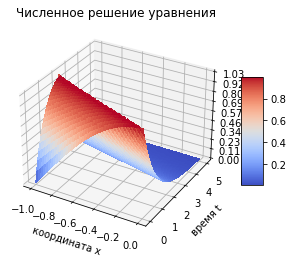

In [9]:
# 3D график
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

xx, tt = np.meshgrid(x, t)
surf = ax.plot_surface(
    xx, tt, np.transpose(u), cmap=cm.coolwarm, linewidth=0, antialiased=False
)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Численное решение уравнения")
ax.set_xlabel("координата x")
ax.set_ylabel("время t")
ax.set_zlabel("u")

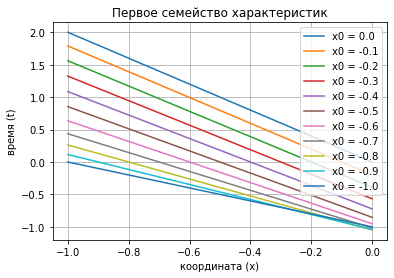

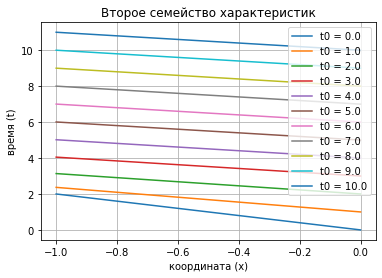

In [10]:
# 1 характеристики
fig1, ax1 = plt.subplots()
for k in np.linspace(X, X0, 11):
    k = int(k * 10) / 10
    ax1.plot(x, characteristic1(x, k), label="x0 = " + str(k))

ax1.set(
    xlabel="координата (x)",
    ylabel="время (t)",
    title="Первое семейство характеристик",
)
ax1.grid()
ax1.legend()

# 2 характеристики
fig2, ax2 = plt.subplots()
for k in np.linspace(0, 10, 11):
    ax2.plot(x, characteristic2(x, k), label="t0 = " + str(k))

ax2.set(
    xlabel="координата (x)",
    ylabel="время (t)",
    title="Второе семейство характеристик",
)
ax2.grid()
ax2.legend()
plt.show()

In [11]:
@jit(nopython=True)
def difference(N, M, u, u0):
    for n in range(0, N, 2):
        for m in range(0, M, 2):
            p, q = int(n / 2), int(m / 2)
            u0[p, q] = abs(u0[p, q] - u[n, m])
    return u0

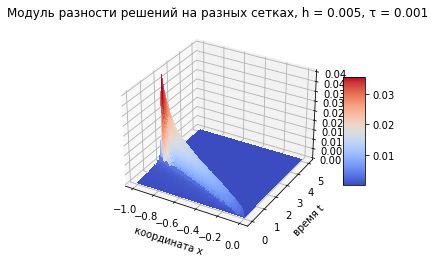

In [17]:
# расчёт на двух разных сетках
N0, M0 = (
    int((N - 1) / 2) + 1,
    int((M - 1) / 2) + 1,
)  # ввожу вторую сетку с шагом, в 2 раза большим
u0 = np.zeros((N0, M0), np.float64)
xx0 = np.linspace(X, X0, N0, dtype=np.float64)
tt0 = np.linspace(0, T, M0, dtype=np.float64)
u0[:, 0] = np.cos(np.pi * xx0 / 2)  # заполняем начальные условия задачи
u0[0, :] = np.exp(-tt0)  # заполняем граничные условия задачи

u0 = solve(u0, N0, M0, 2 * h, 2 * τ)  # расчёт на другой сетке

u0 = difference(N, M, u, u0)

xx, tt = np.meshgrid(xx0, tt0)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    xx,
    tt,
    np.transpose(u0),
    rstride=1,
    cstride=1,
    cmap=cm.coolwarm,
    linewidth=0,
    antialiased=False,
)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(
    f"Модуль разности решений на разных сетках, h = {-h}, τ = {τ}"
)
ax.set_xlabel("координата x")
ax.set_ylabel("время t")
ax.set_zlabel("u")

plt.show()

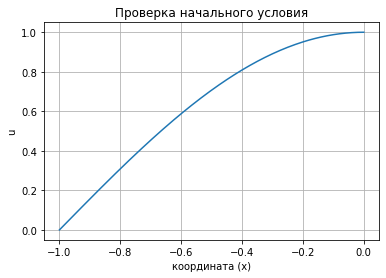

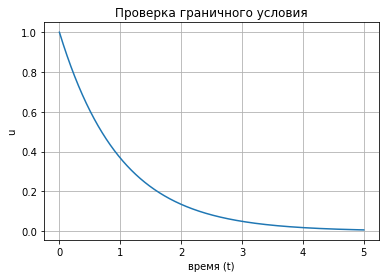

In [12]:
# начальные условия
fig3, ax3 = plt.subplots()
ax3.plot(x, u[:, 0])

ax3.set(
    xlabel="координата (x)", ylabel="u", title="Проверка начального условия"
)
ax3.grid()

# граничные условия
fig4, ax4 = plt.subplots()
ax4.plot(t, u[0, :])

ax4.set(xlabel="время (t)", ylabel="u", title="Проверка граничного условия")
ax4.grid()
plt.show()

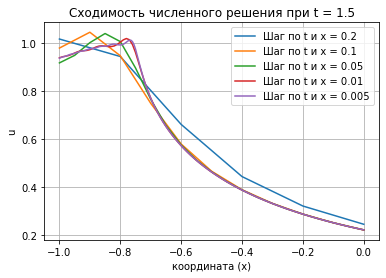

In [13]:
# проверка сходимости
fig1, ax1 = plt.subplots()
ht = [0.2, 0.1, 0.05, 0.01, 0.005]

for step in ht:
    NN, MM = (
        int((X - X0) / step) + 1,
        int(T / step) + 1,
    )  # количество шагов по x и t
    MM0 = int(time / step) + 1
    uu = np.zeros((NN, MM), float)
    Xx, Tt = np.linspace(X, X0, NN), np.linspace(0, T, MM)
    uu[:, 0] = np.cos(np.pi * Xx / 2)  # заполняем начальные условия задачи
    uu[0, :] = np.exp(-Tt)  # заполняем граничные условия задачи
    uu = solve(uu, NN, MM0, -step, step)
    ax1.plot(Xx, uu[:, MM0 - 1], label=f"Шаг по t и x = {step}")

ax1.set(
    xlabel="координата (x)",
    ylabel="u",
    title=f"Сходимость численного решения при t = {time}",
)
ax1.grid()
ax1.legend()
plt.show()

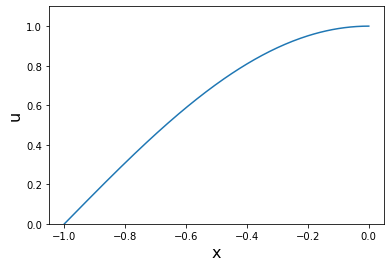

In [13]:
# анимация
fig, ax = plt.subplots()
ax.set_ylim(0, 1.1)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
(line,) = ax.plot(x, u[..., 0])


def init():
    line.set_ydata([np.nan] * len(x))
    return (line,)


def animate(i):
    line.set_ydata(u[..., i])
    return (line,)


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=M, interval=τ
)
#anim.save('видео.gif', fps=30)
plt.show()